In [157]:
import collections
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import random
import math
import featuretools as ft
from featexp import get_univariate_plots,get_trend_stats
warnings.filterwarnings("ignore")
# %matplotlib inline

In [222]:
ft

<module 'featuretools' from '/home/qibo/anaconda3/lib/python3.6/site-packages/featuretools/__init__.py'>

In [61]:
# !python -m pip install featuretools
# !pip install featexp

In [1]:
data_path = '/home/chenxiaotian/Projects/xiamen_match/data'
# test.csv  train.csv  train_target.csv
tra_x = pd.read_csv(data_path + '/train.csv')
tra_y = pd.read_csv(data_path + '/train_target.csv')

In [15]:
def cal_ks(y, yhat):
    ks_dict = {}
    df = pd.DataFrame(columns=['label','score'])
    df.label = y
    df.score = yhat
    cross_freq = pd.crosstab(df.score, df.label)
    cross_dens = cross_freq.cumsum(axis=0)/cross_freq.sum()
    cross_dens['gap'] = abs(cross_dens[0]-cross_dens[1])
    ks = cross_dens[cross_dens['gap'] == cross_dens['gap'].max()]
    return ks, cross_dens


def cal_psi(score, pre_score, length=10):
    labels=['c'+str(i) for i in range(length)]
    True_out,bins=pd.qcut(score,q=length,retbins=True,labels=labels)
    bins[0] = bins[0]-0.001 #cut左开右闭，之前最小值再分组后组记号为空，这里减0.01划到最左侧区间
    
    Pre_out,bins_=pd.cut(pre_score,bins=bins,retbins=True,labels=labels)
    
    a=pd.DataFrame(pd.Series(True_out).value_counts()).rename(columns={0:'val1'})
    a=a.applymap(lambda y : y/len(a))
    
    b=pd.DataFrame(pd.Series(Pre_out).value_counts()).rename(columns={0:'val2'})
    b=b.applymap(lambda y : y/len(b))
    
    re=pd.merge(a,b,left_index=True,right_index=True)
    
    psi=0
    for i in range(len(re)):
        if re['val1'][i]==0:
            re['val1'][i]=0.000001
        if re['val2'][i]==0:
            re['val2'][i]=0.000001
        p=((re['val2'][i]-re['val1'][i])*(math.log((re['val2'][i]/re['val1'][i]))))
        
        psi=psi+p
    return psi

In [30]:
es = ft.EntitySet(id="all_data")

In [ ]:
# 流程
    - 先不用第三方数据；
    - 检测是否有嵌套表： 例如用户表里嵌套设备表
        - how? 列相关性
        - 没有！
    - 类别性+类别形 = 类别性， 这当然是最主要的特征拓展方式；
        - 可以自己写个transform 类别源文件 trend;
    - 类别个数缩减，例如原来100个，可是80个都很稀疏，自动缩减为other类
        - 可以自己写个transform 同样是类比 trend, 只不过这里去拿 target;
    

# featexp 
    - 有很多 null-0-1 变量 怎么处理？
        - 数一数null 
    - 现在是噪声，但是变量组合以后未必是 例如 age?
    - 多类别形怎么处理？ 例如地区市
        - 应该展示最主要的k个bins
    
# featuretools
    - certId，dist实际是身份证前6位，只需要四位
    - age 看起来是诡异的噪声
    - basicLevel
    

In [76]:
import random

In [153]:
tra_id = set(random.sample(range(final.shape[0]),70000))
val_id = set(range(final.shape[0])) - tra_id
tra_id = [i for i in tra_id]
val_id = [i for i in val_id]

In [171]:
final['dist']= final.dist.apply(lambda x: int(x/100))

In [217]:
[i for i in final.corr().values[0] if i==1]

[1.0]

In [219]:
cor = final.corr()

In [221]:
for j in range(final.shape[1]):
    tmp = [i for i in cor.values[0] if i==1]
    if len(tmp)>=1:
        print('hhhh')

hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh
hhhh


In [178]:
final['dist'].value_counts()

7101     2409
6401     2317
6403     2085
3101     1902
6452     1726
5101     1673
6405     1617
6408     1467
5505     1415
5607     1378
5303     1371
6409     1327
7001     1319
6201     1285
7002     1236
5301     1211
6301     1154
8101     1150
5506     1107
6101     1088
6413      978
6414      968
6406      961
6415      949
7301      931
5501      924
6509      908
6419      902
5205      880
6501      876
         ... 
11000       7
8530        7
6190        6
5590        6
7402        5
7403        5
6604        5
5414        5
7404        5
7422        4
7423        4
6204        4
5790        4
7421        3
6390        3
6226        3
8323        3
4290        3
8327        2
8326        2
6603        2
8302        2
3490        2
5409        2
7425        1
7424        1
7426        1
8505        1
7405        1
8324        1
Name: dist, Length: 483, dtype: int64

In [ ]:

get_trend_stats(data=final.iloc[tra_id,:], target_col='target', data_test=final.iloc[val_id,:],
                     features_list=[], bins=483)

                                             Plots for id                                             
                                           Train data plots                                           


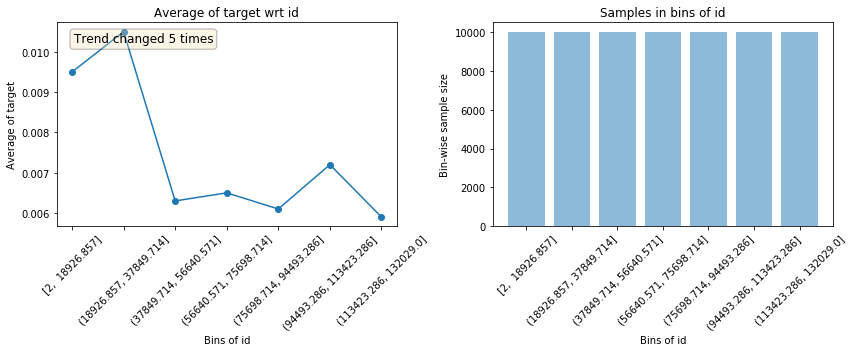

                                           Test data plots                                            


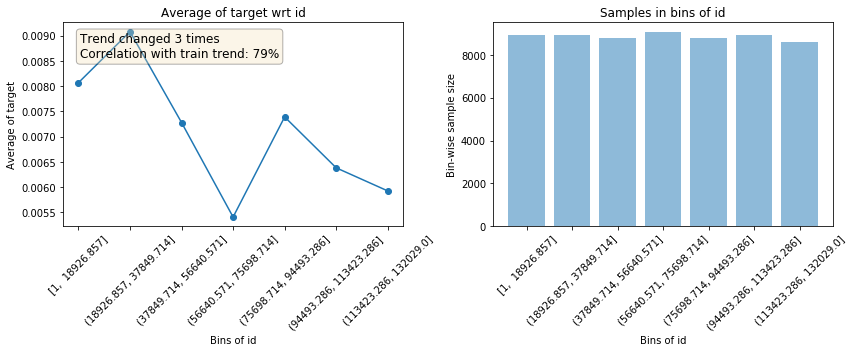

--------------------------------------------------------------------------------------------------------------


                                           Plots for certId                                           
                                           Train data plots                                           


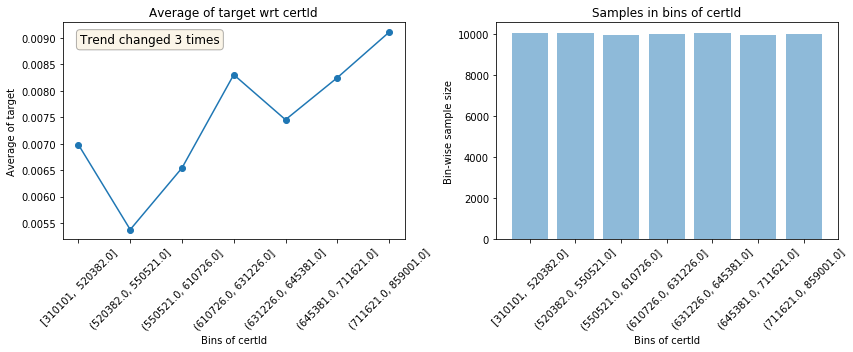

                                           Test data plots                                            


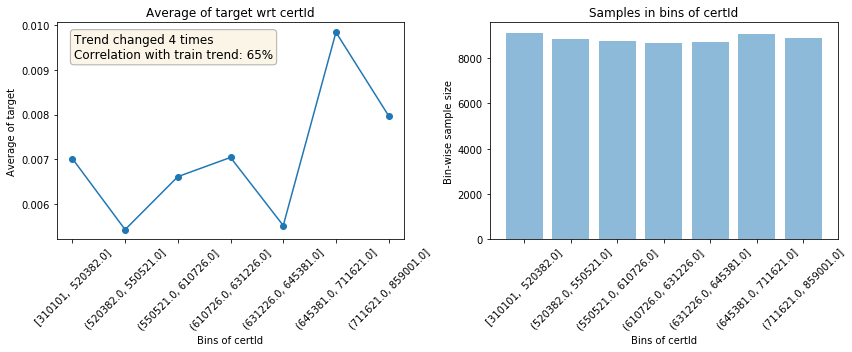

--------------------------------------------------------------------------------------------------------------


                                        Plots for loanProduct                                         
                                           Train data plots                                           


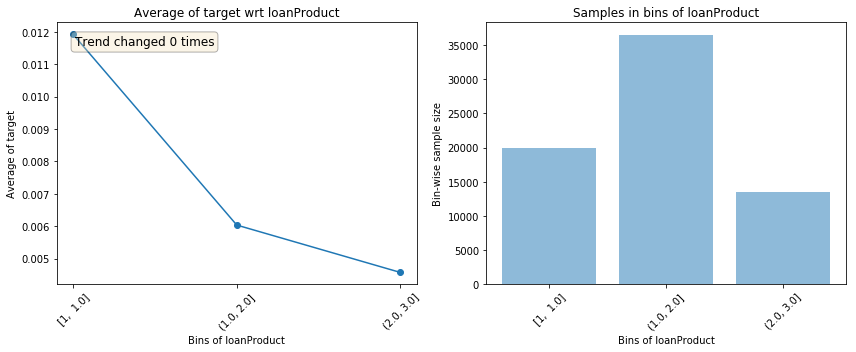

                                           Test data plots                                            


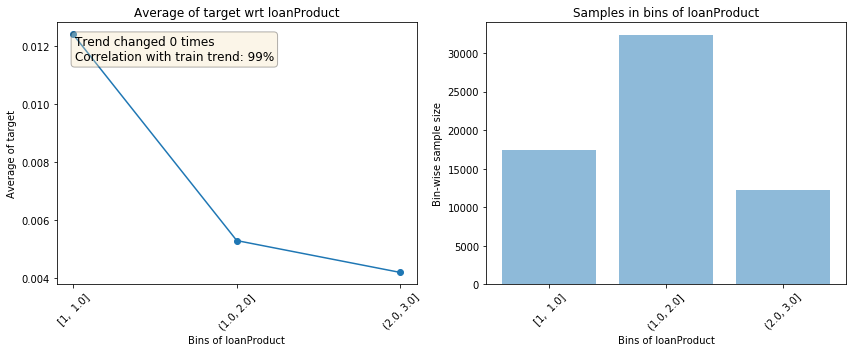

--------------------------------------------------------------------------------------------------------------


                                           Plots for gender                                           
                                           Train data plots                                           


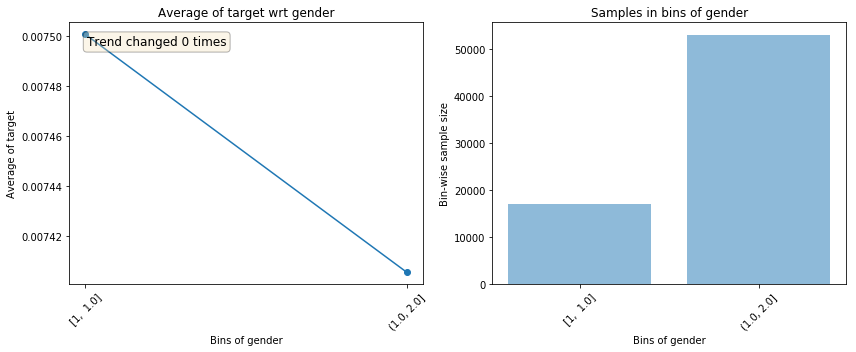

                                           Test data plots                                            


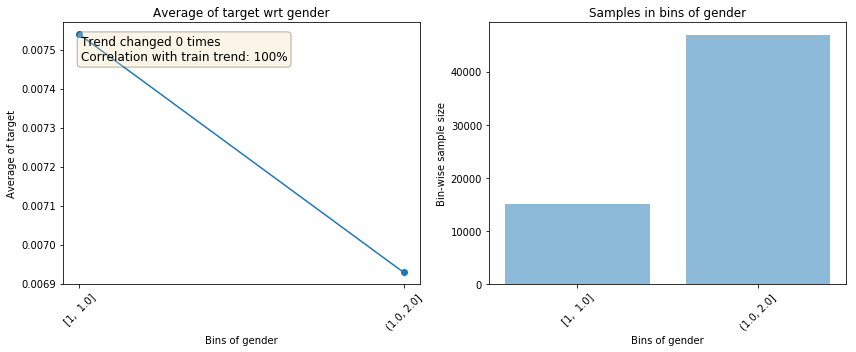

--------------------------------------------------------------------------------------------------------------


                                            Plots for age                                             
                                           Train data plots                                           


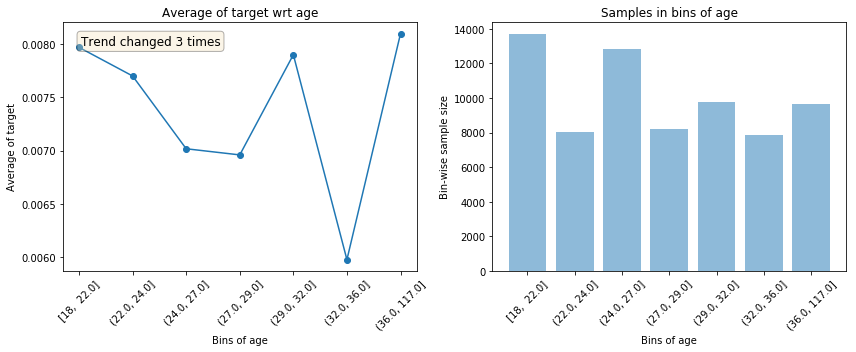

                                           Test data plots                                            


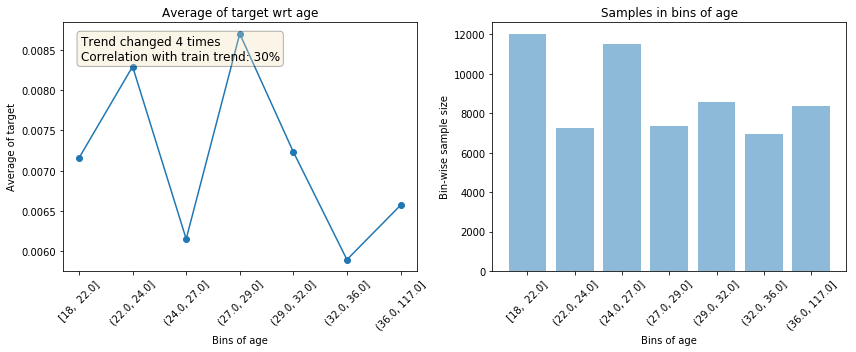

--------------------------------------------------------------------------------------------------------------


                                            Plots for dist                                            
                                           Train data plots                                           


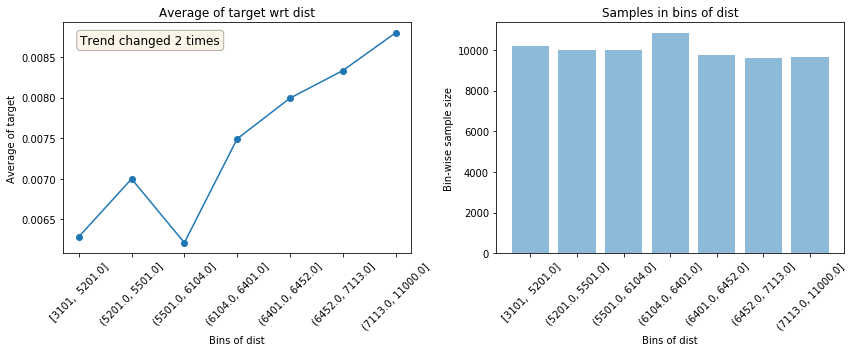

                                           Test data plots                                            


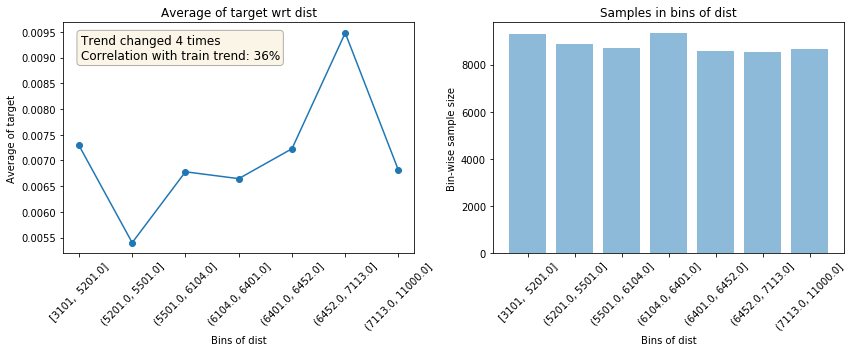

--------------------------------------------------------------------------------------------------------------


                                            Plots for edu                                             
                                           Train data plots                                           


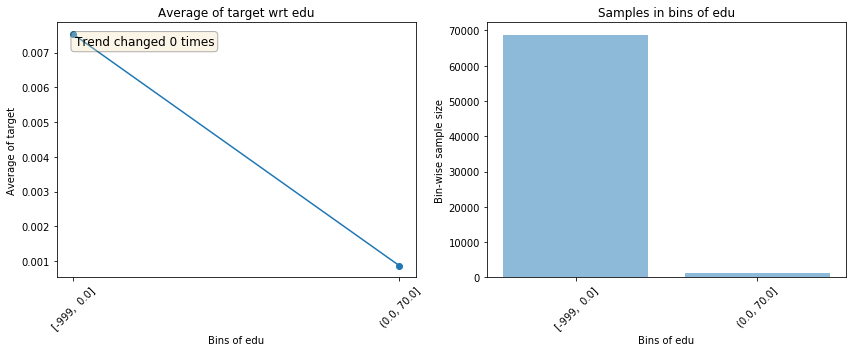

                                           Test data plots                                            


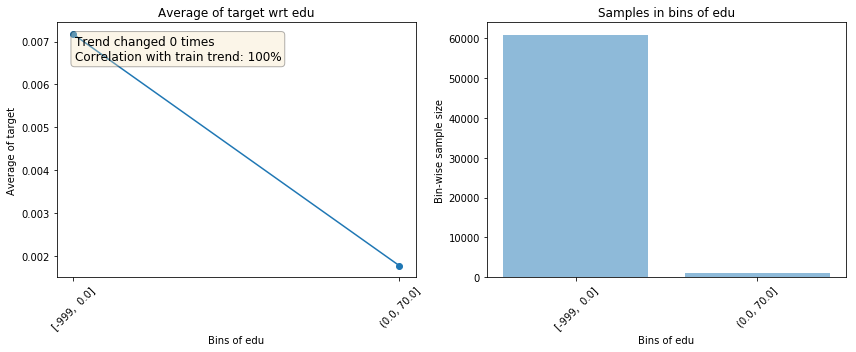

--------------------------------------------------------------------------------------------------------------


                                            Plots for job                                             
                                           Train data plots                                           


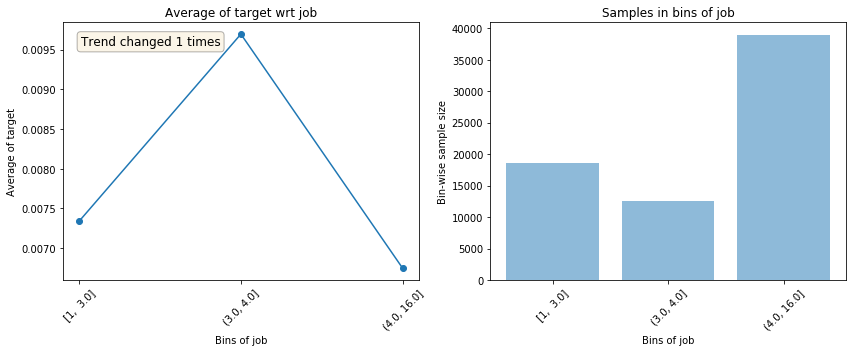

                                           Test data plots                                            


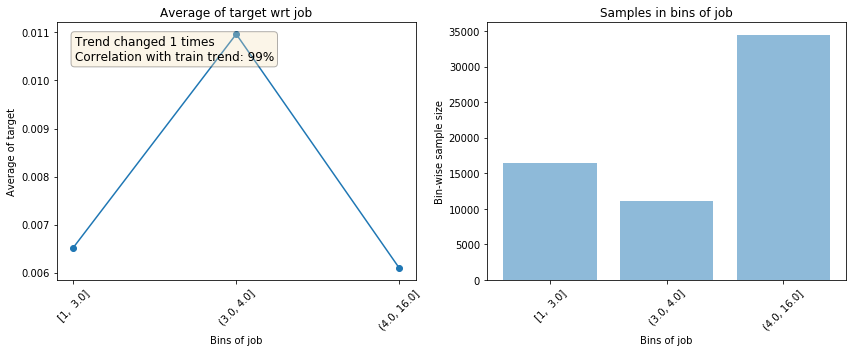

--------------------------------------------------------------------------------------------------------------


                                            Plots for lmt                                             
                                           Train data plots                                           


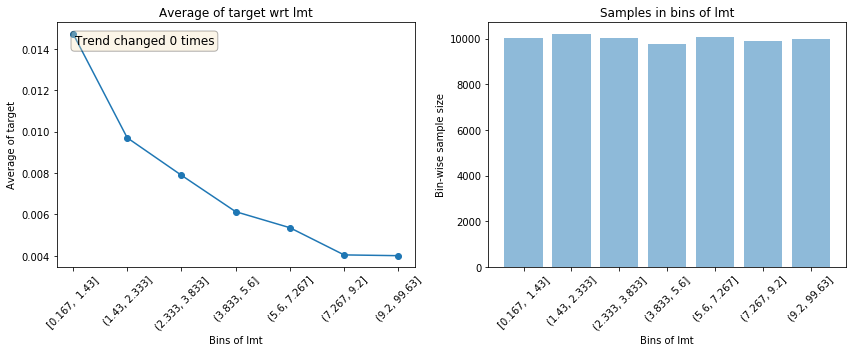

                                           Test data plots                                            


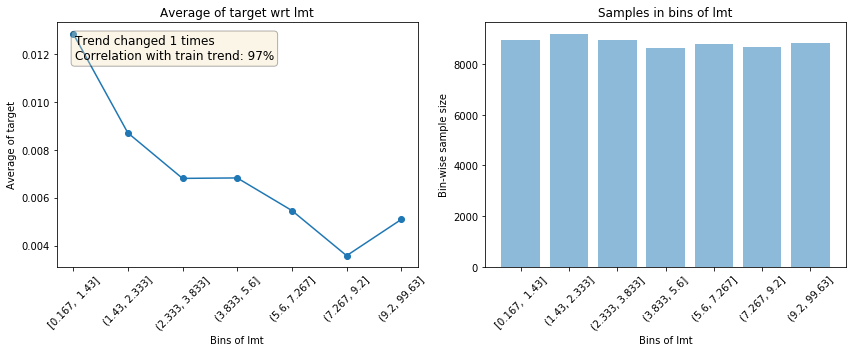

--------------------------------------------------------------------------------------------------------------


                                         Plots for basicLevel                                         
                                           Train data plots                                           


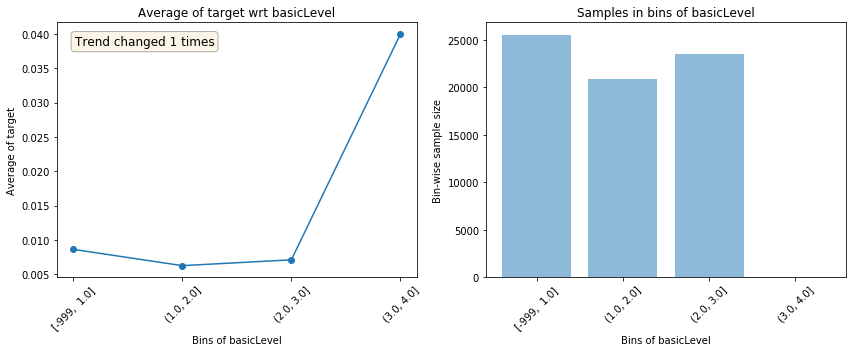

                                           Test data plots                                            


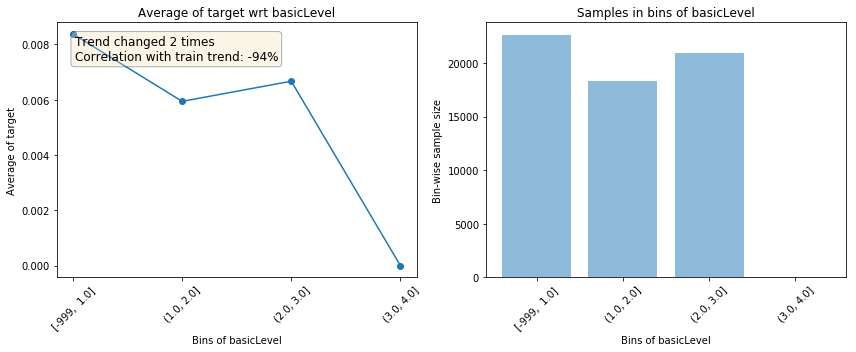

--------------------------------------------------------------------------------------------------------------




In [172]:
get_univariate_plots(data=final.iloc[tra_id,:], target_col='target', data_test=final.iloc[val_id,:],
                     features_list=final.columns[:10], bins=7)

In [164]:
final.tail()

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,...,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,isNew,target
132024,132025,631023,2,2,22,631023,0,4,7.867,2,...,11,12,6,1,0,1,0,0,0,0
132025,132026,640711,1,2,26,640700,0,4,4.630,1,...,0,11,1,1,0,1,1,0,0,0
132026,132027,550424,2,2,30,550424,0,16,2.200,3,...,0,7,1,1,0,1,0,0,0,0
132027,132028,430104,1,1,48,430100,0,4,1.996,1,...,1,17,5,1,0,1,1,0,0,0
132028,132029,520723,2,2,26,520723,0,16,7.667,3,...,1,17,4,1,1,1,1,0,0,0


In [152]:
ts = 3698352000
time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(ts))

'2087-03-13 08:00:00'

In [145]:
def timestamp_to_date(time_stamp, format_string="%Y-%m-%d %H:%M:%S"):
    time_array = time.localtime(time_stamp)
    str_date = time.strftime(format_string, time_array)
    return str_date

In [146]:
import time

In [149]:
import time 
timeNum = 3698352000
timeStamp = float(timeNum/1000) 
timeArray = time.localtime(timeStamp) 
time.strftime("%Y-%m-%d %H:%M:%S", timeArray) 


'1970-02-13 03:19:12'

In [140]:
t1 = 3666124800.0

In [141]:
t2  = 3981744000.0

In [144]:
print(datetime.fromtimestamp(t2))


2096-03-05 08:00:00


In [ ]:
3698352000

In [ ]:
x_33

In [103]:
final[['x_1', 'target']].x_1.value_counts()

 0      131718
-999       311
Name: x_1, dtype: int64

In [66]:
final = tra_x.merge(tra_y,on='id')

In [59]:
es['all_data'].df

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,...,highestEdu,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,isNew
1,1,640582,1,2,27,640500,0,8,5.963,3,...,-999,0,9,6,1,0,1,0,0,1
2,2,621023,2,2,25,640600,0,3,6.467,3,...,99,11,6,5,1,0,1,0,0,1
3,3,641283,1,2,37,641200,70,5,0.596,1,...,70,0,1,6,0,0,0,0,0,1
4,4,340821,3,2,29,340821,0,4,6.300,3,...,-999,-999,13,6,1,0,1,0,0,1
5,5,732628,2,2,22,732628,0,2,6.700,2,...,99,11,8,3,1,0,1,0,0,1
6,6,610221,3,2,27,610221,0,4,5.867,3,...,-999,-999,11,3,1,0,1,1,0,1
7,7,629004,1,1,31,620100,0,3,12.630,1,...,-999,0,17,5,1,1,0,1,0,1
8,8,822223,1,2,32,822223,0,3,1.096,1,...,99,0,14,6,1,1,1,0,0,1
9,9,632503,1,2,27,640700,0,4,0.830,2,...,-999,0,2,6,0,0,1,0,0,1
10,10,722323,2,2,37,722300,0,3,7.667,1,...,-999,12,17,5,0,0,1,0,0,1


In [38]:
es = es.entity_from_dataframe(entity_id="all_data", 
                              dataframe=tra_x, 
                              index="id")


In [188]:
gps = ft.list_primitives().groupby('type')

In [190]:
dfs=[]
for i,j in gps:
    dfs.append(j)

In [194]:
dfs[0].name.tolist()

['trend',
 'first',
 'num_true',
 'skew',
 'max',
 'mode',
 'mean',
 'count',
 'all',
 'last',
 'any',
 'percent_true',
 'std',
 'num_unique',
 'median',
 'min',
 'avg_time_between',
 'entropy',
 'sum',
 'time_since_last',
 'time_since_first',
 'n_most_common']

In [198]:
dfs[1].name.tolist()[2]

'latitude'

In [213]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="all_data",
                                      agg_primitives = dfs[0].name.tolist(),
                                      trans_primitives = dfs[1].name.tolist()[:5],
                                      max_depth = 2)

In [214]:
feature_matrix.shape

(132029, 412)

In [ ]:
cv_train = lgb.Dataset(Final_x, Final_y.astype('int'))
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'num_threads': 10,
          'num_leaves': 3,  # 31,
          'learning_rate': 0.008,  # 0.002
          'feature_fraction': 0.5,
          'lambda_l2': 140,
          'bagging_fraction': 0.5,
          'bagging_freq': 5}
gbm = lgb.cv(params,
             cv_train,
             num_boost_round=5000,
             nfold=5,
             early_stopping_rounds=100,
             verbose_eval=200)
return gbm['auc-mean'][-1], gbm['auc-stdv'][-1]